<a href="https://colab.research.google.com/github/fclubb/EarthSurfaceProcesses/blob/master/Week2_HillslopeEvolution/2DHillslope_ANSWERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hillslope evolution in 2D using Landlab - Answers

This notebook shows you some potential answers to the questions set out in the soil production function practicals. Your plots and answers might look different, and that's fine - it will depend on the parameters you chose to explore and how you chose to make your figures.

## Setting up the model

Before we can answer any of the questions, we set up the model using the same code as at the start of the practical notebook:



## Installing Landlab
Google Colab doesn't have landlab installed automatically, so we will have to run some code to install it. To do that, run the below code block. This will output a lot of text which you can ignore.
**You should only need to do this once when you start the notebook up - if you restart the runtime, then there is no need to re-run this code block**

In [ ]:
!pip install numpy==1.20.1 &> /dev/null
!pip install landlab &> /dev/null

**Now on to the code example**

Import statements. You should not need to edit this.


In [ ]:
# below is to make plots show up in the notebook
%matplotlib inline

**IF YOU GET AN ERROR HERE, click on "Runtime" in the top menu, and then "Restart runtime". Then try running this cell again.**

In [ ]:
# Code Block 1

import numpy as np
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim

from landlab.plot.imshow import imshow_grid

We will create a grid with 50 rows and 50 columns, and dx (the model resolution, or size of each pixel) is 5 m. The initial elevation is 0 at all nodes.

We set-up boundary conditions so that material can leave the hillslope at the two short ends.

In [ ]:
# Code Block 2

# setup grid
from landlab import RasterModelGrid

mg = RasterModelGrid((50, 50), 5.0)
z_vals = mg.add_zeros("topographic__elevation", at="node")

# initialize some values for plotting
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ys_grid = ycoord_rast[:, 2]

# set boundary condition.
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)

Now we import and initialize the *LinearDiffuser* component. 

IMPORTANT: In this block we set the "D" parameter which is the diffusivity parameter in the linear hillslope equation.

In [ ]:
# Code Block 3

from landlab.components import LinearDiffuser

D = 0.01  # initial value of 0.01 m^2/yr
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=D)

**Exercises:**
1. In the example illustrated here: $D$ = 0.01 m$^2$yr$^{-1}$, and $U$ = 0.0001 m yr$^{-1}$. Restart everything, and use the model to determine how long it takes for the landscape to go from a flat to reach 50%, 75% and 100% of its steady-state morphology. Does the landscape approach steady state linearly in time? (You can run the time loop (Code Block 7) multiple times without running other code blocks again to continually evolve the landscape. You will initially want to rerun all the code blocks and change the value of **run_time** (Code Block 4). Determining the correct value of **run_time** to use will take some iteration.


_To answer this question, you need to change the *runtime* parameter in Code Block 4 and then experiment with how long you need to run the model for before it reaches 50% of steady state. The default run time was 1,000,000 years. After half of the run time (500,000 years) the model had achieved just over 50% of steady state (shown by the black line in the figure below):_

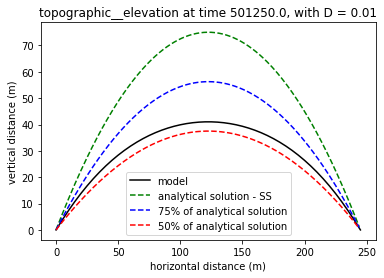



_After the full runtime of 1 million years, the model had achieved just over 75% of steady state:_

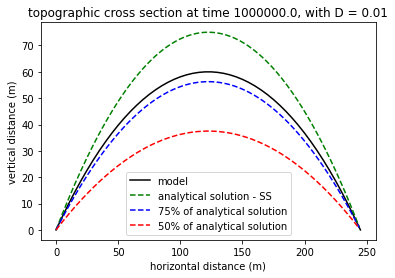

*Importantly, every time I change the run time and re-run Code Block 7, the model will ADD runtime on to the topography that has already evolved (it won't start from a flat surface again). If you want to start from a flat surface, you have to go back and run all code blocks from Code Block 2.*

*To try and get the model to full steady state, I changed the runtime to 100,000 years and then ran Code Block 7 and 8 again. This will add 100,000 years to the total runtime which is already 1 million years.*

*I found I had to run Code Blocks 7 and 8 another 20 times to get to steady state! The model reached the analytical solution at 3 million years.*

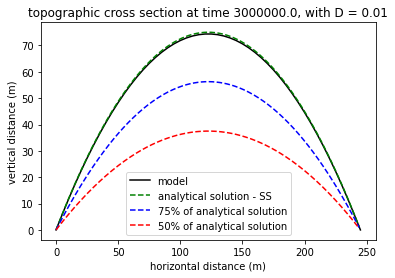

*This suggests the time to steady state is non-linear: it took only 500,000 years for the model to reach 50% of steady state, but another 500,000 years to get to 75%, and then another 2 MILLION years on top of that to reach 100% of steady state.*

In [ ]:
# Code Block 4

# Uniform rate of rock uplift
uplift_rate = 0.0001  # meters/year, originally set to 0.0001

# Total time in years that the model will run for.
runtime = 100000  # years, originally set to 1,000,000. Changed to 100,000 to try and find steady state.

# Stability criteria for timestep dt.  Coefficient can be changed
# depending on our tolerance for stability vs tolerance for run time.
dt = 0.5 * mg.dx * mg.dx / D

# nt is number of time steps
nt = int(runtime // dt)

# Below is to keep track of time for labeling plots
# NOTE - I CHANGED THIS TO 1 MILLION TO GET CORRECT LABELLING FOR MY STEADY STATE PLOTS
time_counter = 1000000

# length of uplift over a single time step, meters
uplift_per_step = uplift_rate * dt

In [ ]:
# Code Block 5

ys = np.arange(mg.number_of_node_rows * mg.dx - mg.dx)

# location of divide or ridge crest -> middle of grid
# based on boundary conds.
divide_loc = (mg.number_of_node_rows * mg.dx - mg.dx) / 2

# half-width of the ridge
half_width = (mg.number_of_node_rows * mg.dx - mg.dx) / 2

# analytical solution for elevation under linear diffusion at steady state
zs = (uplift_rate / (2 * D)) * (np.power(half_width, 2) - np.power(ys - divide_loc, 2))

In [ ]:
# Code Block 7

for i in range(nt):
    mg["node"]["topographic__elevation"][mg.core_nodes] += uplift_per_step
    lin_diffuse.run_one_step(dt)
    time_counter += dt

    # All landscape evolution is the first two lines of loop.
    # Below is simply for plotting the topography halfway through the run
    if i == int(nt // 2):
        figure(1)
        imshow_grid(mg, "topographic__elevation")
        title("topography at time %s, with D = %s" % (time_counter, D))
        figure(2)
        elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
        plot(ys_grid, elev_rast[:, 2], "k-", label="model")
        plot(ys, zs, "g--", label="analytical solution - SS")
        plot(ys, zs * 0.75, "b--", label="75% of analytical solution")
        plot(ys, zs * 0.5, "r--", label="50% of analytical solution")
        xlabel("horizontal distance (m)")
        ylabel("vertical distance (m)")
        legend(loc="lower center")
        title("topographic__elevation at time %s, with D = %s" % (time_counter, D))

Now we plot the final cross-section.

In [ ]:
# Code Block 8

elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
plot(ys_grid, elev_rast[:, 2], "k-", label="model")
plot(ys, zs, "g--", label="analytical solution - SS")
plot(ys, zs * 0.75, "b--", label="75% of analytical solution")
plot(ys, zs * 0.5, "r--", label="50% of analytical solution")
xlabel("horizontal distance (m)")
ylabel("vertical distance (m)")
legend(loc="lower center")
title("topographic cross section at time %s, with D = %s" % (time_counter, D))

2. What do you think will happen when you increase $D$ (Code Block 3) by a factor of 10? Will the time to steady state differ? If yes, how? Will the topography be different? If yes, how and why? What does it mean physically, about processes, if $D$ increases? Answer these questions before running any code. 


_This was a question for you to think about before you ran any code! You should have looked at your lecture notes and thought about what D actually means. D is the diffusivity coefficient in the linear diffusion model, which tells us something about the efficiency of hillslope processes such as soil creep. If D is higher, then it means that these processes are acting more efficiently. I would therefore expect that the model would reach steady state faster, as the topography could evolve more quickly to compensate rock uplift. 

3. Now set $D$ = 0.1 m$^2$yr$^{-1}$ and rerun landscape evolution from an initial flat. Illustrate the final steady state topography and record the time to steady state. Discuss how the landscape differs from the results in question 1. Discuss how the results are similar to or different from your intuition. It is OK if your intuition was wrong! 


4. What do you think will happen when you increase **uplift_rate** (Code Block 4) by a factor of 10? Will the time to steady state differ? If yes, how? Will the topography be different? If yes, how and why? Answer these questions first, and then rerun the code with **uplift_rate** = 0.001 m yr$^{-1}$. (Make sure you change $D$ - Code Block 3 - back to the original value of 0.01 m$^2$yr$^{-1}$ and restart from a flat surface.) Illustrate the final steady state topography. Discuss how these results differ from the results in question 1 and how the results match (or do not) your intuition. It is OK if your intuition was wrong.

Now we plot the steepest slope in the downward direction across the landscape.

(To calculate the steepest slope at a location, we need to route flow across the landscape.)

In [ ]:
# Code Block 9

from landlab.components import FlowAccumulator

fr = FlowAccumulator(mg)  # intializing flow routing
fr.run_one_step()
plot(
    mg.node_y[mg.core_nodes],
    mg.at_node["topographic__steepest_slope"][mg.core_nodes],
    "k-",
)
xlabel("horizontal distance (m)")
ylabel("topographic slope (m/m)")
title("slope of the hillslope at time %s, with D = %s" % (time_counter, D))

Has the landscape reached steady state yet? How do you know?







Answer: Not quite, but it is getting close. Go back and rerun Code Blocks 7, 8 and 9 (time loop and plotting). (Remember you can rerun a cell with shift-return, or from the cell pull-down menu.) Has it reached steady state yet?  